# NLP model for sentiment analysis.

## Trained on twitter comments

In [1]:
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D
from keras.layers import Dropout, Embedding
from keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model

<a href="https://www.kaggle.com/takuok/glove840b300dtxt">Link for downloading EMBEDDING_FILE used below.</a>

In [3]:
EMBEDDING_FILE = glove.840B.300d.txt # Not included in the repo due tolarge size of 5GB.
train_x = pd.read_csv('./datasets/train_preprocessed.csv').fillna(" ")
test_x = pd.read_csv('./datasets/test_preprocessed.csv').fillna(" ")

In [4]:
max_features=100000
maxlen=150
embed_size=300

In [5]:
train_x['comment_text'].fillna(' ')
test_x['comment_text'].fillna(' ')
train_y = train_x[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
train_x = train_x['comment_text'].str.lower()

In [6]:
test_x = test_x['comment_text'].str.lower()

Vectorize text + Prepare GloVe Embedding

In [7]:
tokenizer = text.Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(train_x))

In [8]:
import pickle

In [9]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

In [8]:
train_x = sequence.pad_sequences(train_x, maxlen=maxlen)
test_x = sequence.pad_sequences(test_x, maxlen=maxlen)

In [9]:
embeddings_index = {} ## dictionary for maintaining each word's coefficients array present in glove.txt
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [10]:
word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Model Building

In [11]:
inp = Input(shape=(maxlen,))

In [12]:
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
## input_dim = max_features
## output_dim = embed_size
x = SpatialDropout1D(0.35)(x)

In [13]:
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

In [14]:
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])

In [15]:
out = Dense(6, activation='sigmoid')(x)

In [16]:
model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Prediction

In [17]:
batch_size = 32
epochs = 1

In [18]:
model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1)
predictions = model.predict(test_x, batch_size=batch_size, verbose=1)

4787/4787 [==============================] - 433s 90ms/step


In [27]:
model.save("model.h5")

In [14]:
features = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

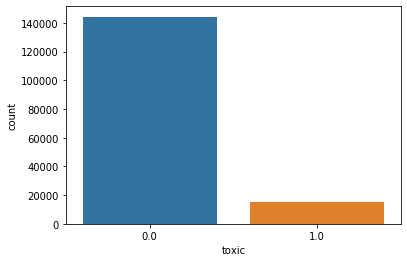

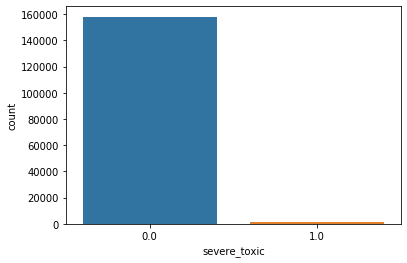

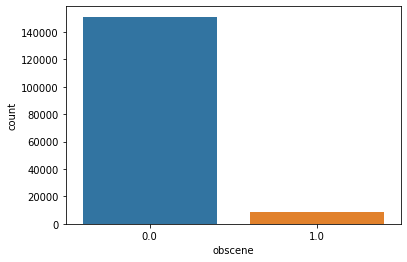

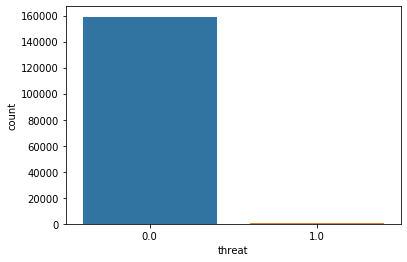

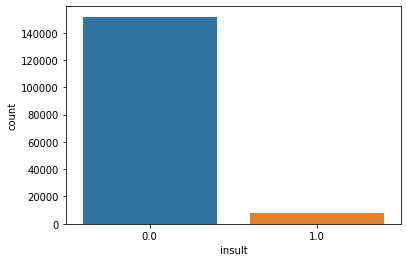

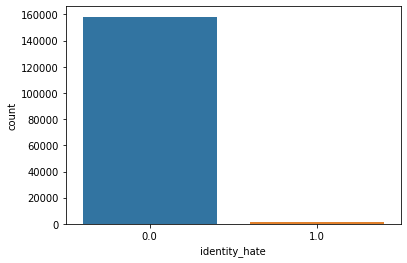

In [17]:
import matplotlib.pyplot as plt

for feature in features:
    sns.countplot(x=feature, data=train_x)
    plt.show()

### Model Optimization/Quantization and Evaluation

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

import pathlib

#this model is not included here in the repo.
tflite_models_dir = pathlib.Path("/tmp/my_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"final_model.tflite"
tflite_model_file.write_bytes(tflite_model)

#this is the model used in deployment because of less size and almost same accuracy as the original model.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"final_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

!dir -lh {tflite_models_dir}

In [ ]:
category = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
from Preprocess import PatternTokenizer
tokenizer_2 = PatternTokenizer()
test = [["I will kill you ."]]
data = pd.DataFrame(test)
data[0] = tokenizer_2 .process_ds(data[0]).str.join(sep=" ")
data = data[0].str.lower()
data = tokenizer.texts_to_sequences(data)
data = sequence.pad_sequences(data, maxlen=maxlen)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="final_model.tflite")
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, data.astype(np.float32))
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)
print(predictions)
result_tflite = category[predictions.argmax()]
print(result_tflite) ## "threat" is printeds

In [ ]:
interpreter2 = tf.lite.Interpreter(model_path="final_model_quant.tflite")
interpreter2.allocate_tensors()
input_index2 = interpreter2.get_input_details()[0]["index"]
output_index2 = interpreter2.get_output_details()[0]["index"]
interpreter2.set_tensor(input_index2, data.astype(np.float32))
interpreter2.invoke()
predictions2 = interpreter2.get_tensor(output_index2)
print(predictions2)
result_tflite_quant = category[predictions2.argmax()]
print(result_tflite_quant) ## "threat" is printed